In [1]:
import numpy as np
import random
import torch
import torch.nn as nn 
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary 
from torchmetrics import Accuracy, F1Score
import os

In [2]:
# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
"""torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False"""

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(15),          
    transforms.ToTensor()                   
])

test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),          
    transforms.ToTensor()                  
])

# Load the full CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_val_transform)

# Split the training dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Apply the validation transform to the validation dataset
val_dataset.dataset.transform = test_val_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check the sizes
print(f"Image size: {next(iter(train_dataset.dataset))[0].shape}")
print(f"Train size: {len(train_loader.dataset)}")
print(f"Validation size: {len(val_loader.dataset)}")
print(f"Test size: {len(test_loader.dataset)}")

Files already downloaded and verified
Files already downloaded and verified
Image size: torch.Size([3, 224, 224])
Train size: 40000
Validation size: 10000
Test size: 10000


In [3]:
classes = train_dataset.dataset.classes
mini_batch_image, labels = next(iter(train_loader))
print(f"mini-batch shape: {mini_batch_image.shape}")
print(classes) 

mini-batch shape: torch.Size([64, 3, 224, 224])
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip

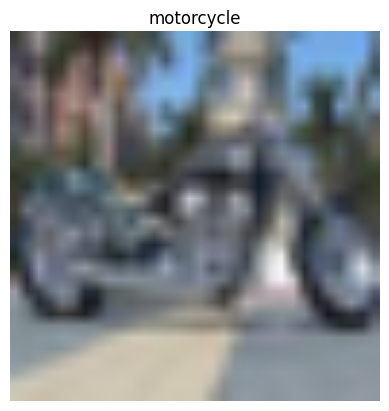

In [4]:
idx = np.random.randint(0,15) 
sample_image = mini_batch_image[idx].permute(1,2,0)
plt.imshow(sample_image)
plt.title(classes[labels[idx].item()]) 
plt.axis("off");

In [5]:
class BasicNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(64,128 , kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.2)
        ) 
        self.classifier = nn.Linear(256, num_classes) 
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor to shape (batch_size, 256)
        x = self.classifier(x)
        return x

In [6]:
spatial_model = BasicNet(100)
device = torch.device("cuda")
spatial_model.to(device)
summary(spatial_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
       BatchNorm2d-3         [-1, 32, 224, 224]              64
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
              ReLU-6         [-1, 64, 112, 112]               0
       BatchNorm2d-7         [-1, 64, 112, 112]             128
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
             ReLU-10          [-1, 128, 56, 56]               0
      BatchNorm2d-11          [-1, 128, 56, 56]             256
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
             ReLU-14          [-1, 256,

## Training & Validation 

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(spatial_model.parameters(), lr= 0.005)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [8]:
save_dir = 'baseline_cnn_spatial'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

EPOCHS = 200 
BATCH_SIZE = 64
train_cost, val_cost = [],[]
train_acc, val_acc = [],[]
early_stopping_patience = 10
best_val_loss = float('inf')
early_stop_counter = 0


for epoch in range(EPOCHS):
    train_loss = 0 
    acc_train = Accuracy('multiclass', num_classes=100).to(device)
    spatial_model.train().cuda()  # set the model for training 

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        pred = spatial_model(images)
        curr_loss = criterion(pred, labels)
        train_loss += curr_loss.item()

        curr_loss.backward()
        optimizer.step()

        acc_train(pred, labels)
        
    train_cost.append(train_loss / len(train_loader))
    train_acc.append(acc_train.compute()) 


    val_loss = 0 
    acc_val = Accuracy(task="multiclass", num_classes=100).to(device)
    spatial_model.eval().cuda()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            pred = spatial_model(images)

            curr_loss = criterion(pred, labels)
            val_loss += curr_loss.item()

            _, predicted = torch.max(pred, 1)
            acc_val(predicted, labels)

    val_cost.append(val_loss / len(val_loader))
    val_acc.append(acc_val.compute())

    print(f"[{epoch+1}\{EPOCHS}], train-loss: {train_cost[-1]}, train-acc: {acc_train.compute()}, val-loss: {val_cost[-1]}, val-acc: {acc_val.compute()}")
#     torch.save(spatial_model.state_dict(), f'baseline_cnn_spatial/checkpoint_{epoch + 1}') 

    scheduler.step(val_cost[-1])
    
    if val_cost[-1] < best_val_loss:
        best_val_loss = val_cost[-1]
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
torch.save(spatial_model.state_dict(), 'baseline_cnn_spatial/spatial_model.pth') 

[1\200], train-loss: 3.9895055019378662, train-acc: 0.08962500095367432, val-loss: 3.7363097834738954, val-acc: 0.1316000074148178
[2\200], train-loss: 3.5700002109527587, train-acc: 0.15702499449253082, val-loss: 3.3984328318553367, val-acc: 0.18479999899864197
[3\200], train-loss: 3.2128935962677003, train-acc: 0.22197499871253967, val-loss: 3.2635443878781265, val-acc: 0.2143000066280365
[4\200], train-loss: 2.941388988494873, train-acc: 0.27355000376701355, val-loss: 2.9022127868263583, val-acc: 0.2824999988079071
[5\200], train-loss: 2.717379458427429, train-acc: 0.3163999915122986, val-loss: 2.6840612372015693, val-acc: 0.3278999924659729
[6\200], train-loss: 2.56554938621521, train-acc: 0.3470250070095062, val-loss: 2.5857281973407527, val-acc: 0.3490000069141388
[7\200], train-loss: 2.4347443058013916, train-acc: 0.37447500228881836, val-loss: 2.4384042077763066, val-acc: 0.3765000104904175
[8\200], train-loss: 2.3324699937820434, train-acc: 0.3948499858379364, val-loss: 2.2877

## Testing 

In [7]:
final_spatial_model = BasicNet(100)
final_spatial_model.load_state_dict(torch.load("spatial_model.pth"))

<All keys matched successfully>

In [8]:
acc = Accuracy(task="multiclass", num_classes=100).to(device)
f1 = F1Score('multiclass', num_classes=100).to(device)

final_spatial_model.eval().cuda()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        predictions = final_spatial_model(images) 

        _, predicted = torch.max(predictions, 1)

        acc(predicted, labels)
        f1(predicted, labels)


print(f"Test Accuracy: {acc.compute().data:.3f}")
print(f"F1 : {f1.compute().data:.3f}")

Test Accuracy: 0.525
F1 : 0.525
